In [1]:
import genesis as gs
import numpy as np
import torch
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)

import spatialmath as sm
from pandaSim.geometry.genesis_adapter import GenesisAdapter
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner

In [2]:
gs.init(backend=gs.cpu, seed=42)

[Genesis] [11:54:48] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [11:54:48] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [11:54:48] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [11:54:51] [INFO] Running on [13th Gen Intel(R) Core(TM) i7-13800H] with backend gs.cpu. Device memory: 31.59 GB.
[Genesis] [11:54:51] [INFO] 🚀 Genesis initialized. 🔖 version: 0.2.1, 🌱 seed: 42, 📏 precision: '32', 🐛 debug: False, 🎨 theme: 'dark'.


In [3]:
adapter = GenesisAdapter()
scene = adapter.scene

[Genesis] [11:54:54] [INFO] Scene <5753a72> created.


In [4]:
plane = scene.add_entity(
    gs.morphs.Plane(),
)
franka = scene.add_entity(
    gs.morphs.MJCF(file='xml/franka_emika_panda/panda.xml'),
)
                          
# table = scene.add_entity(
#     gs.morphs.MJCF(file='../model/common_arena/tables.xml'),
# )

table1 = scene.add_entity(
    gs.morphs.Box(
        size = (0.7, 1.7, 0.02),
        pos = (0.5, 0, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0
    )
)
        
table2 = scene.add_entity(
    gs.morphs.Box(
        size = (0.7, 1.7, 0.02),
        pos = (-0.5, 0, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0
    )
)

table3 = scene.add_entity(
    gs.morphs.Box(
        size = (0.3, 0.7, 0.02),
        pos = (0, -0.5, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0
    )
)

table4 = scene.add_entity(
    gs.morphs.Box(
        size = (0.3, 0.7, 0.02),
        pos = (0, 0.5, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0
    )
)
         
bottle = scene.add_entity(
    material=gs.materials.Rigid(rho=300),
    morph=gs.morphs.URDF(
        file="urdf/3763/mobility_vhacd.urdf",
        scale=0.09,
        pos=(0.65, 0.0, 0.036 + 0.19),
        quat=(-np.pi/2, 0, np.pi/2, 0),
    ),
    # visualize_contact=True,
)

cube_size = (0.07, 0.1, 0.1)
cube_pos = (0.4, 0.4, 0.05+0.19)

cube = scene.add_entity(
    gs.morphs.Box(
        size = cube_size,
        pos  = cube_pos,
    ),
    surface=gs.surfaces.Default(
        color = (0.8, 0.1 , 0.1),   
    )
)
cube.surface.color = (0.8, 0.1 , 0.1)

cylinder_pos = (0.7, -0.2, 0.03+0.19)
cylinder_quat = (0, -np.sqrt(2)/2, 0, np.sqrt(2)/2)
cylinder_radius = 0.03
cylinder_height = 0.15

cylinder = scene.add_entity(
    gs.morphs.Cylinder(
        radius = cylinder_radius,
        height = cylinder_height,
        pos    = cylinder_pos,
        quat   = cylinder_quat,
    ),
    surface=gs.surfaces.Default(
        color = (0.1, 0.8 , 0.1),   
    )
)
cylinder.surface.color = (0.2, 0.8, 0.2)

cam = scene.add_camera(
    res    = (640, 480),
    pos    = (3.5, 0.0, 2.5),
    lookat = (0, 0, 0.5),
    fov    = 30,
    GUI    = False,
)


[Genesis] [11:55:04] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <170a86e>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [11:55:04] [INFO] Adding <gs.RigidEntity>. idx: 1, uid: <52fd8b4>, morph: <gs.morphs.MJCF(file='d:\envs\pygen\Lib\site-packages\genesis\assets\xml/franka_emika_panda/panda.xml')>, material: <gs.materials.Rigid>.
[Genesis] [11:55:07] [WARNING] (MJCF) Tendon not supported
[Genesis] [11:55:07] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint1`
[Genesis] [11:55:07] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [11:55:07] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint2`
[Genesis] [11:55:07] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [11:55:08] [INFO] Adding <gs.RigidEntity>.

In [5]:
scene.build()

[Genesis] [11:55:17] [INFO] Building scene <5753a72>...
[Genesis] [11:55:22] [WARNING] Reference robot position exceeds joint limits.
[Genesis] [11:55:22] [WARNING] Constraint solver time constant was increased to avoid numerical instability (from `0.005` to `0.02`). Decrease simulation timestep to avoid altering the original value.
[Genesis] [11:55:43] [INFO] Compiling simulation kernels...
[Genesis] [12:10:48] [INFO] Building visualizer...
[Genesis] [12:11:23] [INFO] Viewer created. Resolution: 1280×960, max_FPS: 60.


In [10]:
motors_dof = np.arange(7)
fingers_dof = np.arange(7, 9)
# set control gains
# Note: the following values are tuned for achieving best behavior with Franka
# Typically, each new robot would have a different set of parameters.
# Sometimes high-quality URDF or XML file would also provide this and will be parsed.
franka.set_dofs_kp(
    np.array([4500, 4500, 3500, 3500, 2000, 2000, 2000, 100, 100]),
)
franka.set_dofs_kv(
    np.array([450, 450, 350, 350, 200, 200, 200, 10, 10]),
)
franka.set_dofs_force_range(
    np.array([-87, -87, -87, -87, -12, -12, -12, -100, -100]),
    np.array([ 87,  87,  87,  87,  12,  12,  12,  100,  100]),
)

# render rgb, depth, segmentation, and normal
# rgb, depth, segmentation, normal = cam.render(rgb=True, depth=True, segmentation=True, normal=True)

In [11]:
# get bottle properties
bottle_pos = bottle.get_pos()
print(f"bottle_pos: {bottle_pos}")
bottle_rot = bottle.get_quat()
print(f"bottle_rot: {bottle_rot}")
bottle_mass = bottle.get_mass()
print(f"bottle_mass: {bottle_mass}")

planner = ScrewMotionPlanner()
bottle_bbox = adapter.get_bbox(bottle)
planner.find_ground_edges(bottle_bbox)
bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
print(f"bottle screw params qs: {bottle_qs}")
print(f"bottle screw params s_axes: {bottle_s_axes}")
# bottle_vertices = bottle.get_verts()
# print(f"bottle_vertices: {bottle_vertices}")
bottle_bbox = bottle.get_AABB()
bottle.size = bottle_bbox[1] - bottle_bbox[0]

# get cubes prperties
cube_pos = cube.get_pos()
print(f"cube_pos: {cube_pos}")
cube_rot = cube.get_quat()
print(f"cube_rot: {cube_rot}")
cube_mass = cube.get_mass()
print(f"cube_mass: {cube_mass}")
cube_vertices = cube.get_verts()
print(f"cube_vertices: {cube_vertices}")

cube.size = cube_size

# get cylinder properties
cylinder_pos = cylinder.get_pos()
print(f"cylinder_pos: {cylinder_pos}")
cylinder_rot = cylinder.get_quat()
print(f"cylinder_rot: {cylinder_rot}")
cylinder_mass = cylinder.get_mass()
print(f"cylinder_mass: {cylinder_mass}")
# cylinder_vertices = cylinder.get_verts()
# print(f"cylinder_vertices: {cylinder_vertices}")
cylinder.size = (cylinder_height, cylinder_radius)

bottle_pos: tensor([0.6500, 0.0000, 0.2260])
bottle_rot: tensor([-0.7071,  0.0000,  0.7071,  0.0000])
bottle_mass: 0.09222162768927847
bottle screw params qs: [[5.6069762e-01 4.7992636e-04 1.9216135e-01]
 [7.2746480e-01 4.7992636e-04 1.9216135e-01]]
bottle screw params s_axes: [[0. 1. 0.]
 [0. 1. 0.]]
cube_pos: tensor([0.4000, 0.4000, 0.2400])
cube_rot: tensor([1., 0., 0., 0.])
cube_mass: 0.14000000000000004
cube_vertices: tensor([[0.3650, 0.3500, 0.1900],
        [0.3650, 0.3500, 0.2900],
        [0.3650, 0.4500, 0.1900],
        [0.3650, 0.4500, 0.2900],
        [0.4350, 0.3500, 0.1900],
        [0.4350, 0.3500, 0.2900],
        [0.4350, 0.4500, 0.1900],
        [0.4350, 0.4500, 0.2900]])
cylinder_pos: tensor([ 0.7000, -0.2000,  0.2200])
cylinder_rot: tensor([ 0.0000, -0.7071,  0.0000,  0.7071])
cylinder_mass: 0.0842790191109674


In [ ]:
def get_obj_screw(object):
    """
    Get the screw parameters of the object
    """
    if object == bottle:
        planner = ScrewMotionPlanner()
        bottle_bbox = adapter.get_bbox(bottle)
        planner.find_ground_edges(bottle_bbox)
        bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
        s1, s2 = bottle_s_axes
        q1, q2 = bottle_qs
        h1 = 0
        h2 = 0
    else:
        # get the vertices of the object
        vertices = object.get_verts()
        vertices = vertices.numpy()

        # get the max and min x, y, z coordinates
        max_x = np.max(vertices[:, 0])
        min_x = np.min(vertices[:, 0])
        min_y = np.min(vertices[:, 1])
        min_z = np.min(vertices[:, 2])
        max_y = np.max(vertices[:, 1])
        
        v1 = np.array([max_x, min_y, min_z])  # max x, min y, min z
        v2 = np.array([max_x, max_y, min_z])  # max x, max y, min z
        v3 = np.array([min_x, max_y, min_z])  # min x, max y, min z
        v4 = np.array([min_x, min_y, min_z])  # min x, min y, min z
        
        if np.linalg.norm(v1-v2) <= np.linalg.norm(v2-v3):
            s1 = (v1-v2) / np.linalg.norm(v1-v2) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v4-v3) / np.linalg.norm(v4-v3) # unit vector in the direction of the screw axis
            q2 = v4 # point on the screw axis
            h2 = 0 # pitch of the screw axis
        else:
            s1 = (v2-v3) / np.linalg.norm(v2-v3) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v1-v4) / np.linalg.norm(v1-v4) # unit vector in the direction of the screw axis
            q2 = v1 # point on the screw axis
            h2 = 0 # pitch of the screw axis
    
    #pt.check_screw_parameters(q, s, h) # check if the screw parameters are valid
    return s1, q1, h1, s2, q2, h2


def obj_dq(object, method):
    """
    Get the screw parameters of the object and apply sclerp to the object in dual quaternion
    """
    if method == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2

    
    pq = object.get_qpos().cpu().numpy()
    pq = pq[0:7] # position and quaternion of the object
    obj_initial_dq = pt.dual_quaternion_from_pq(pq) # dual quaternion from position and quaternion
    
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    # intermediate_T = pt.transform_log_from_screw_matrix
    # Screw_T = pt.transform_from_dual_quaternion(Screw_dq) # transform from dual quaternion to transformation matrix
    # print("screw_dq: \n", Screw_dq)
    # print("screw_T: \n", Screw_T)
    obj_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, obj_initial_dq)
    #obj_goal_T = pt.transform_from_dual_quaternion(obj_goal_dq) # transform from dual quaternion to transformation matrix
    # print("obj_goal_dq: \n", obj_goal_dq)
    # print("obj_goal_T: \n", obj_goal_T)
    return obj_initial_dq, obj_goal_dq


def obj_sclerp(object, obj_initial_dq, obj_goal_dq, method, steps):
    """
    Apply sclerp to the object in dual quaternion
    """
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    dq_traj = [pt.dual_quaternion_sclerp(obj_initial_dq, obj_goal_dq, t) for t in tau]
         # spherical linear interpolation between two dual quaternions
    # get the position and quaternion from the dual quaternion
    dq_traj = np.asarray(dq_traj)
    obj_qpos = ptr.pqs_from_dual_quaternions(dq_traj)
    
    return dq_traj, obj_qpos

def obj_grasp_offset(object, object_initial_dq, method):
    
    m = 1
    if method == 'min_distance':
        m = -1
    
    if object == cube:
        length = cube.size[0]
        width = cube.size[1]
        height = cube.size[2]    
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, m*(-width/2 + 0.02)],
                             [0, 0, 1, height/2 - 0.02],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 1, 0, 0],
                         [1, 0, 0, 0],
                         [0, 0, -1, 0.11],
                         [0, 0, 0, 1]])
 
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == cylinder:
        length = cylinder.size[0]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, -m*(-length/2 + 0.02)],
                             [0, 0, 0, 1]])
        # T_ee = np.array([[1, 0, 0, 0],
        #                  [0, -1, 0, 0],
        #                  [0, 0, -1, 0.11],
        #                  [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, 1, -0.11],
                         [0, 1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == bottle:
        length = bottle.size[0]
        width = bottle.size[1]
        height = bottle.size[2]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) 
        T_offset = np.array([[1, 0, 0, m*(-0.01)],
                             [0, 1, 0, 0],
                             [0, 0, 1, m*(-0.04)],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, -1, 0.11],
                         [0, -1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        T_grasp = T_initial @ T_offset @ T_ee       
    return T_grasp
    
def obj_grasp(object, method):
    """
    grasping the object
    """
    
    # get the dual quaternion of the object
    obj_initial_dq, obj_goal_dq = obj_dq(object, method)

    T_grasp = obj_grasp_offset(object, obj_initial_dq, method) 
    print("T_grasp: \n", T_grasp)
    pq_grasp = pt.pq_from_transform(T_grasp) # position and quaternion from transformation matrix
    return pq_grasp


def franka_sclerp(object, robot, method, method2, steps):
    franka_initial_p, franka_initial_q = robot.forward_kinematics(robot.get_qpos(), links_idx_local=[8])
    franka_initial_pq = np.concatenate((franka_initial_p, franka_initial_q), axis=1).reshape(7) # position and quaternion of the end effector
    franka_initial_dq = pt.dual_quaternion_from_pq(franka_initial_pq) # dual quaternion from position and quaternion
    if method2 == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method2 == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2
        
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    franka_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, franka_initial_dq)
    
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    franka_dq_traj = [pt.dual_quaternion_sclerp(franka_initial_dq, franka_goal_dq, t) for t in tau]# spherical linear interpolation between two dual quaternions
    franka_dq_traj = np.asarray(franka_dq_traj)
    # get the position and quaternion from the dual quaternion
    franka_pqs = ptr.pqs_from_dual_quaternions(franka_dq_traj)
    return franka_pqs

def Success_Rate(obj_goal_T, obj_current_T):
    """
    Compare the goal and current transformation and give a success rate based on that.
    """
    # get the rotation matrix from the transformation matrix
    obj_goal_R = obj_goal_T[:3, :3]
    obj_current_R = obj_current_T[:3, :3]
    
    # get the translation vector from the transformation matrix
    obj_goal_t = obj_goal_T[:3, 3]
    obj_current_t = obj_current_T[:3, 3]
    
    # get the angle between the two rotation matrices
    angle = np.arccos((np.trace(obj_goal_R.T @ obj_current_R) - 1) / 2)
    angle_rate = 1 - abs(angle) / (np.pi/2)
    
    # get the distance between the two translation vectors
    distance = np.linalg.norm(obj_goal_t - obj_current_t)
    distance_rate = 1 - distance / (np.linalg.norm(obj_goal_t))
        
    success_rate = (4*angle_rate + distance_rate)/5
    
    return success_rate

In [ ]:
# p, q = franka.forward_kinematics(franka.get_qpos(), links_idx_local=[8])
# franka_pq = np.concatenate((p, q), axis=1).reshape(7) # position and quaternion of the end effector
# franka_pq
# franka_T = pt.transform_from_pq(franka_pq) # transformation matrix from position and quaternion
# print("franka_T: \n", franka_T)

In [ ]:
# # check if the end effector is in the right pregrasp pose
# print("pregrasp pose: ", pq_grasp_cube)
# print("end effector pose: ", end_effector.get_pos())

### Uprighting the bottle

In [ ]:
bottle.get_pos()

In [53]:
# franka is in ready position
scene.reset()
bottle.set_pos([0, -0.45, 0.035+0.19])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [13:39:07] [INFO] Resetting Scene <5753a72>.


In [54]:
# move to pre-grasp pose for bottle
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_bottle = obj_grasp(bottle, 'min_distance')
print(pq_grasp_bottle)
print(pt.transform_from_pq(pq_grasp_bottle))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_bottle[:3] , # position of the end effector
    quat = pq_grasp_bottle[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 1.00000000e+00  0.00000000e+00  2.22044605e-16 -4.00000000e-02]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00 -4.49999988e-01]
 [ 2.22044605e-16  0.00000000e+00 -1.00000000e+00  3.44018991e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-4.00000000e-02 -4.49999988e-01  3.44018991e-01  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.11022302e-16]
[[ 1.00000000e+00  0.00000000e+00  2.22044605e-16 -4.00000000e-02]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00 -4.49999988e-01]
 [ 2.22044605e-16  0.00000000e+00 -1.00000000e+00  3.44018991e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [55]:
# closing fingers to grasp the bottle
franka.control_dofs_force(np.array([-5, -5]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [56]:
# franka sclerp to upright the bottle
franka_pqs = franka_sclerp(cylinder, franka, method='quintic', method2='min_distance', steps=500)
init_q = franka.get_qpos() 
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

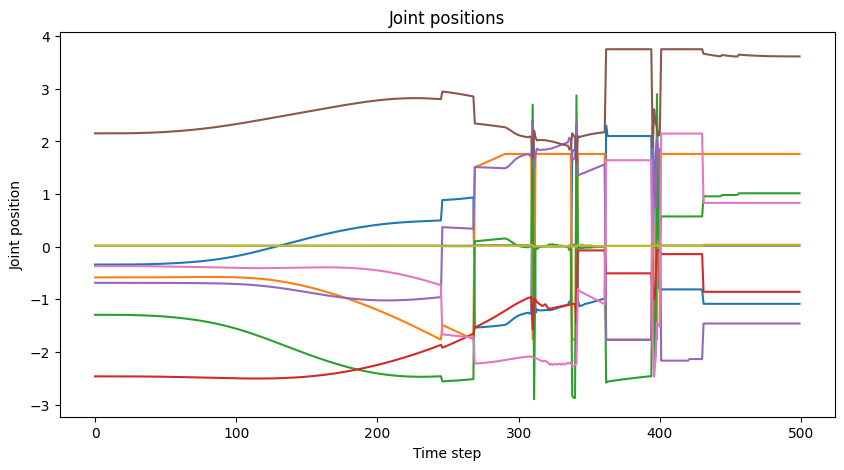

In [57]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [58]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step() 

KeyboardInterrupt: 

### Uprighting the cylinder

In [78]:
# franka is in ready position
scene.reset()
cylinder.set_pos([0.45, -0.25, 0.03 +0.19])
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'min_distance')
cyl_goal_T = pt.transform_from_dual_quaternion(cyl_goal_dq)
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [14:16:31] [INFO] Resetting Scene <5753a72>.


In [67]:
# move to pre-grasp pose for cylinder
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cylinder = obj_grasp(cylinder, 'min_distance')
print(pq_grasp_cylinder)
print(pt.transform_from_pq(pq_grasp_cylinder))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cylinder[:3] , # position of the end effector
    quat = pq_grasp_cylinder[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 9.99999999e-01  3.60835940e-09 -3.89436854e-05  5.05005345e-01]
 [ 3.66456964e-09 -1.00000000e+00  1.44337215e-06 -2.50000188e-01]
 [-3.89436854e-05 -1.44337229e-06 -9.99999999e-01  3.29962675e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 5.05005345e-01 -2.50000188e-01  3.29962675e-01 -7.21686112e-07
  1.00000000e+00  1.81823226e-09 -1.94718427e-05]
[[ 9.99999999e-01  3.60835940e-09 -3.89436854e-05  5.05005345e-01]
 [ 3.66456964e-09 -1.00000000e+00  1.44337215e-06 -2.50000188e-01]
 [-3.89436854e-05 -1.44337229e-06 -9.99999999e-01  3.29962675e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [68]:
# closing fingers to grasp the cylinder
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [69]:
# franka sclerp to upright the cylinder
franka_pqs = franka_sclerp(cylinder, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

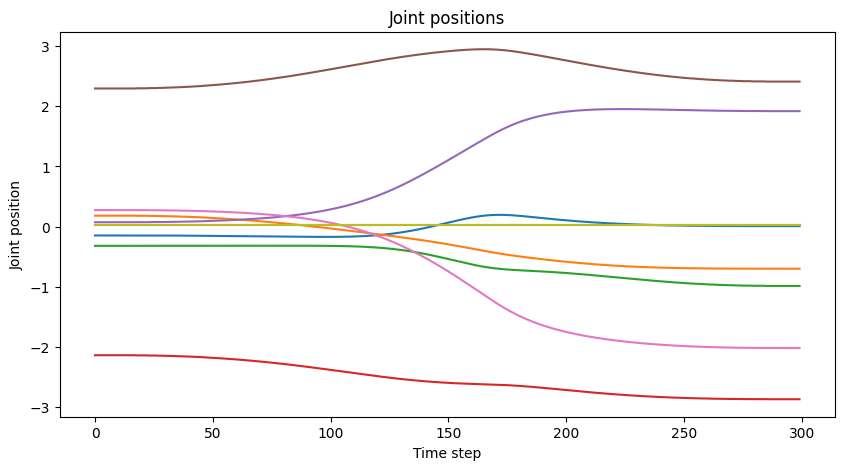

In [70]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [71]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   
    

In [72]:
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for _ in range(150):
    
    scene.step()

In [95]:
cyl_current_T = pt.transform_from_pq(cylinder.get_qpos())
Success_Rate(cyl_goal_T, cyl_current_T)

np.float64(0.15443869412408065)

### Uprighting the cube

In [49]:
# franka is in ready position
scene.reset()
cube.set_pos([0.45,0.1,0.04+0.19])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [13:04:34] [INFO] Resetting Scene <5753a72>.


In [50]:
# move to pre-grasp pose for cube
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cube = obj_grasp(cube, 'min_distance')
print(pq_grasp_cube)
print(pt.transform_from_pq(pq_grasp_cube))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cube[:3] , # position of the end effector
    quat = pq_grasp_cube[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 0.          1.          0.          0.44999999]
 [ 1.          0.          0.          0.13      ]
 [ 0.          0.         -1.          0.369019  ]
 [ 0.          0.          0.          1.        ]]
[0.44999999 0.13       0.369019   0.         0.70710678 0.70710678
 0.        ]
[[-2.22044605e-16  1.00000000e+00  0.00000000e+00  4.49999988e-01]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00  1.30000001e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  3.69019001e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [51]:
# closing fingers to grasp the cube
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [ ]:
# franka sclerp to upright the cube
franka_pqs = franka_sclerp(cube, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

In [ ]:
# damping = 1e-6
# diag = damping * np.eye(6)
# for i in range(franka_pqs.shape[0]):
#     # Position error.
#     error_pos = franka_pqs[i][:3] - end_effector.get_pos().cpu().numpy()

#     # Orientation error.
#     ee_quat = end_effector.get_quat().cpu().numpy()
#     error_quat = gs.transform_quat_by_quat(gs.inv_quat(ee_quat), franka_pqs[i][3:7])
#     error_rotvec = gs.quat_to_rotvec(error_quat)

#     error = np.concatenate([error_pos, error_rotvec])

#     # jacobian
#     jac = franka.get_jacobian(link=end_effector).cpu().numpy()
#     dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)
#     q = franka.get_qpos().cpu().numpy() + dq

#     # control
#     franka.control_dofs_position(q)
#     scene.step()

In [ ]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [ ]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   

### Objects Sclerp

In [ ]:
# calling functions for cube_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cube)
cube_initial_dq, Cube_goal_dq = obj_dq(cube, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cube, cube_initial_dq, Cube_goal_dq, 'linear', 100)
dq_traj.shape

In [ ]:
# cube sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cube.set_qpos(obj_qpos[i])
    scene.step()

In [ ]:
# calling functions for cylinder_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cylinder)
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cylinder, cyl_initial_dq, cyl_goal_dq, 'linear', 100)
dq_traj.shape

In [ ]:
# cylinder sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cylinder.set_qpos(obj_qpos[i])
    scene.step()

In [ ]:
# calling functions for bottle_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(bottle)
bottle_initial_dq, bottle_goal_dq = obj_dq(bottle, 'min_distance')

bottle_traj, bottle_qpos = obj_sclerp(bottle, bottle_initial_dq, bottle_goal_dq, 'linear', 100)

In [ ]:
# bottle sclerp motion
scene.reset()
for i in range (bottle_qpos.shape[0]):
    franka.set_qpos(qr)
    bottle.set_qpos(np.append(bottle_qpos[i], [0,0]))
    scene.step()